In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
#!pip install pandas==0.22.0
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np
import random

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#import lime
#import lime.lime_tabular
#from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

import joblib

In [4]:
def train_with_unbalanced_data(X_train, X_test, feature_combiner, dataset_manager, current_args, scaler = None, iterations = 10):
  #index = np.arange(0, len(y_train), 1)
  #X_train = X_train.reindex(index)

  all_pipelines = []
  all_cls = []
  all_acc = []

  for i in range(iterations):

    #X_train_enc = feature_combiner.fit_transform(X_train, y_train)

    y_train = dataset_manager.get_label_numeric(X_train)
    #print(len(y_train))
    case_ids = dataset_manager.get_case_ids(X_train)
    #print(case_ids.shape)

    #Reduce to balanced dataset
    neg_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 0]
    pos_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_cases) > len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(pos_cases)])
    elif len(neg_cases) < len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(neg_cases)])

    y_train_resampled = dataset_manager.get_label_numeric(X_train_resampled)

    #Train model
    if cls_method == "rf":
      cls = RandomForestClassifier(n_estimators=500,
                                  max_features=current_args['max_features'],
                                  random_state=random_state)

    elif cls_method == "xgboost":
      cls = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=500,
                              learning_rate= current_args['learning_rate'],
                              subsample=current_args['subsample'],
                              max_depth=int(current_args['max_depth']),
                              colsample_bytree=current_args['colsample_bytree'],
                              min_child_weight=int(current_args['min_child_weight']),
                              seed=random_state)

    elif cls_method == "logit":
      cls = LogisticRegression(C=2**current_args['C'],
                              random_state=random_state)

    elif cls_method == "svm":
      cls = SVC(C=2**current_args['C'],
                gamma=2**current_args['gamma'],
                random_state=random_state)

    if cls_method == "svm" or cls_method == "logit":
      pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
    else:
      pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

    #print("fitting pipeline...")
    pipeline.fit(X_train_resampled, y_train_resampled)

    #Test Model
    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
    y_test = [dataset_manager.get_label_numeric(group) for _,group in test_all_grouped]

    preds = pipeline.predict(X_test)
    #print(preds)
    acc = accuracy_score(y_test, preds)

    #save to list
    all_pipelines.append(pipeline)
    all_cls.append(cls)
    all_acc.append(acc)
  
  index = all_acc.index(max(all_acc))
    
  print("Accuracy Scores:", all_acc)
  print("Highest accuracy:", max(all_acc))
  print("Index:", index)

  pipeline = all_pipelines[index]
  cls = all_cls[index]

  return pipeline, cls

In [5]:
dataset_ref = "sepsis_cases"
params_dir = PATH + "params/"
results_dir = "results"
bucket_method = "single"
cls_encoding = "agg"
cls_method = "xgboost"
gap = 1
n_iter = 1
balanced_data = False

if bucket_method == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"

method_name = "%s_%s"%(bucket_method, cls_encoding)

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"]#, "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

# create results directory
if not os.path.exists(os.path.join(params_dir)):
    os.makedirs(os.path.join(params_dir))
    
print(datasets)

['sepsis_cases_1']


In [6]:
for dataset_name in datasets:
    
    # load optimal params
    print("Setting up parameters...")
    optimal_params_filename = os.path.join(PATH, params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))

    if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
        print("Parameters not found")
        
    with open(optimal_params_filename, "rb") as fin:
        args = pickle.load(fin)
        
    print(args)
    bucket_list=[5,10,15,20,25] #:)	
            
    # read the data
    print("setting up data...")
    dataset_manager = DatasetManager(dataset_name)
    data = dataset_manager.read_dataset()

    #data = dataset_manager.balance_data(data)
    #print('Case ID column', dataset_manager.case_id_col)
    cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    if "traffic_fines" in dataset_name:
        max_prefix_length = 10
    elif "bpic2017" in dataset_name:
        max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
    else:
        max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

    # split into training and test
    train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")
    
    if gap > 1:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
    else:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
        
    start_test_prefix_generation = time.time()
    dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)
    test_prefix_generation_time = time.time() - start_test_prefix_generation
            
    offline_total_times = []
    online_event_times = []
    train_prefix_generation_times = []

    for ii in range(n_iter):
        # create prefix logs
        print("Creating logs...")
        start_train_prefix_generation = time.time()
        dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)
        train_prefix_generation_time = time.time() - start_train_prefix_generation
        train_prefix_generation_times.append(train_prefix_generation_time)
            
        # Bucketing prefixes based on control flow
        print("bucketing prefixes...")
        bucketer_args = {'encoding_method':bucket_encoding, 
                        'case_id_col':dataset_manager.case_id_col, 
                        'cat_cols':[dataset_manager.activity_col], 
                        'num_cols':[], 
                        'random_state':random_state}
        if bucket_method == "cluster":
            bucketer_args["n_clusters"] = int(args["n_clusters"])
        bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

        start_offline_time_bucket = time.time()
        bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
        offline_time_bucket = time.time() - start_offline_time_bucket

        bucket_assignments_test = bucketer.predict(dt_test_prefixes)

        preds_all = []
        probas_all = []
        pred_types_all = []
        test_y_all = []
        nr_events_all = []
        offline_time_fit = 0
        current_online_event_times = []
        
        for bucket in set(bucket_assignments_test):
            print("Bucket" , bucket, "of", len(set(bucket_assignments_test)))
            print("sorting bucket...")
            #args has only one value - some error and so just using it
            #if bucket_method == "prefix":
            #    current_args = args[bucket]
            #else:
            current_args = args
            
            relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
            relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)
            
            nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
            print('number events', len(nr_events_all))
            
            if len(relevant_train_cases_bucket) == 0:
                preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                current_online_event_times.extend([0] * len(preds))
            
            else:
                dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                train_y = dataset_manager.get_label_numeric(dt_train_bucket)
                test_y  = dataset_manager.get_label_numeric(dt_test_bucket)

                if len(set(train_y)) < 2:
                    preds = [train_y[0]] * len(relevant_test_cases_bucket)
                    current_online_event_times.extend([0] * len(preds))
                    test_y_all.extend(dataset_manager.get_label_numeric(dt_test_bucket))
                else:
                    print("choosing classifier...")
                    start_offline_time_fit = time.time()
                    feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                    if balanced_data==False:
                      pipeline, cls = train_with_unbalanced_data(dt_train_bucket, dt_test_bucket, feature_combiner, dataset_manager, current_args, iterations = 50)

                    else:
                      if cls_method == "rf":
                          cls = RandomForestClassifier(n_estimators=500,
                                                      max_features=current_args['max_features'],
                                                      random_state=random_state)

                      elif cls_method == "xgboost":
                          cls = xgb.XGBClassifier(objective='binary:logistic',
                                                  n_estimators=500,
                                                  learning_rate= current_args['learning_rate'],
                                                  subsample=current_args['subsample'],
                                                  max_depth=int(current_args['max_depth']),
                                                  colsample_bytree=current_args['colsample_bytree'],
                                                  min_child_weight=int(current_args['min_child_weight']),
                                                  seed=random_state)

                      elif cls_method == "logit":
                          cls = LogisticRegression(C=2**current_args['C'],
                                                  random_state=random_state)

                      elif cls_method == "svm":
                          cls = SVC(C=2**current_args['C'],
                                    gamma=2**current_args['gamma'],
                                    random_state=random_state)

                      if cls_method == "svm" or cls_method == "logit":
                          pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
                      else:
                          pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

                      print("fitting pipeline...")
                      pipeline.fit(dt_train_bucket, train_y)
                      
                      offline_time_fit += time.time() - start_offline_time_fit

            # predict separately for each prefix case
            preds = []
            probas = []
            pred_types = []
            
            test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
            print("test data shape", dt_test_bucket.shape)
            count_d=0 # count for deviant
            count_r=0 #count for regular

            tp_list = []
            tn_list = []
            fp_list = []
            fn_list = []

            iteration = 1
            
            for _, group in test_all_grouped:
                print ("Testing instance", iteration, 'of', len(test_all_grouped))
                test_y_group = dataset_manager.get_label_numeric(group)
                test_y_all.extend(test_y_group)
                    
                start = time.time()
                _ = bucketer.predict(group)
                
                if cls_method == "svm":
                    pred = pipeline.decision_function(group)
                else:
                  preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                  pred = pipeline.predict(group)[0]
                  proba = pipeline.predict_proba(group)[:,preds_pos_label_idx]
                pipeline_pred_time = time.time() - start
                current_online_event_times.append(pipeline_pred_time / len(group))
                case_id = dataset_manager.get_case_ids(group)[0]
                
                if test_y_group == pred & pred == 0:
                  pred_type = 'TN'

                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = 1 - proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  tn_list.append(instance_dict)

                elif test_y_group == pred & pred == 1:
                  pred_type = 'TP'
                                    
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  tp_list.append(instance_dict)

                elif test_y_group != pred & pred == 0:
                  pred_type = 'FN'
                  
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = 1 - proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  fn_list.append(instance_dict)

                elif test_y_group != pred & pred == 1:
                  pred_type = 'FP'
                  
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  fp_list.append(instance_dict)
                else:
                  print("ERROR: Prediction doesn't fit into any category. Check code.")
                      
                preds.append(pred)
                probas.extend(proba)
                pred_types.append(pred_type)
                iteration+=1
                
            preds_all.extend(preds)
            probas_all.extend(probas)
            pred_types_all.extend(pred_types)

            tn_path = os.path.join(PATH, "%s/%s_%s/instances/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            tp_path = os.path.join(PATH, "%s/%s_%s/instances/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            fn_path = os.path.join(PATH, "%s/%s_%s/instances/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            fp_path = os.path.join(PATH, "%s/%s_%s/instances/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            
            with open (tn_path, 'wb') as f:
              pickle.dump(tn_list, f)
            with open (tp_path, 'wb') as f:
              pickle.dump(tp_list, f)
            with open (fn_path, 'wb') as f:
              pickle.dump(fn_list, f)
            with open (fp_path, 'wb') as f:
              pickle.dump(fp_list, f)

            #Save models and encoders
            print('Saving models...')
            pipeline_path = os.path.join(PATH, "%s/%s_%s/pipelines/pipeline_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            bucketer_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/bucketer_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            joblib.dump(pipeline, pipeline_path)
            joblib.dump(feature_combiner, feat_comb_path)
            joblib.dump(cls, cls_path)
            joblib.dump(bucketer, bucketer_path)

            #Save training data
            print("saving data...")
            X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_train_path, 'wb') as f:
              pickle.dump(dt_train_bucket, f)
            with open(Y_train_path, 'wb') as f:
              pickle.dump(train_y, f)

            #Save testing data
            X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_test_path, 'wb') as f:
                pickle.dump(dt_test_bucket, f)
            with open(Y_test_path, 'wb') as f:
                pickle.dump(test_y_group, f)
      
        print("compiling results...")
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                print(dataset_name, method_name, cls_method, nr_events, "auc", np.nan)
            else:
                print(dataset_name, method_name, cls_method, nr_events, "auc", roc_auc_score(group.actual, group.predicted))
        print(dataset_name, method_name, cls_method, -1, -1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted))


Setting up parameters...
{'colsample_bytree': 0.9171739872670622, 'learning_rate': 0.5746032369243, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9772254046152622}
setting up data...
Creating logs...
bucketing prefixes...
single
Bucket 1 of 1
sorting bucket...
number events 2493
choosing classifier...
Accuracy Scores: [0.726032892097874, 0.7424789410348978, 0.6915363016446049, 0.7521058965102286, 0.7324508624147613, 0.7099879663056559, 0.7188126754913758, 0.6851183313277176, 0.7152025671881268, 0.7360609707180105, 0.7617328519855595, 0.6979542719614922, 0.6939430405134376, 0.6803048535900521, 0.7364620938628159, 0.7264340152426795, 0.709185720016045, 0.7264340152426795, 0.703971119133574, 0.7051744885679904, 0.7292418772563177, 0.7244283995186522, 0.6895306859205776, 0.7115924588848777, 0.7308463698355395, 0.7452868030485359, 0.740072202166065, 0.7412755716004813, 0.7083834737264341, 0.7115924588848777, 0.7372643401524268, 0.7055756117127958, 0.7055756117127958, 0.7396710790212

Testing instance 239 of 2493
Testing instance 240 of 2493
Testing instance 241 of 2493
Testing instance 242 of 2493
Testing instance 243 of 2493
Testing instance 244 of 2493
Testing instance 245 of 2493
Testing instance 246 of 2493
Testing instance 247 of 2493
Testing instance 248 of 2493
Testing instance 249 of 2493
Testing instance 250 of 2493
Testing instance 251 of 2493
Testing instance 252 of 2493
Testing instance 253 of 2493
Testing instance 254 of 2493
Testing instance 255 of 2493
Testing instance 256 of 2493
Testing instance 257 of 2493
Testing instance 258 of 2493
Testing instance 259 of 2493
Testing instance 260 of 2493
Testing instance 261 of 2493
Testing instance 262 of 2493
Testing instance 263 of 2493
Testing instance 264 of 2493
Testing instance 265 of 2493
Testing instance 266 of 2493
Testing instance 267 of 2493
Testing instance 268 of 2493
Testing instance 269 of 2493
Testing instance 270 of 2493
Testing instance 271 of 2493
Testing instance 272 of 2493
Testing instan

Testing instance 522 of 2493
Testing instance 523 of 2493
Testing instance 524 of 2493
Testing instance 525 of 2493
Testing instance 526 of 2493
Testing instance 527 of 2493
Testing instance 528 of 2493
Testing instance 529 of 2493
Testing instance 530 of 2493
Testing instance 531 of 2493
Testing instance 532 of 2493
Testing instance 533 of 2493
Testing instance 534 of 2493
Testing instance 535 of 2493
Testing instance 536 of 2493
Testing instance 537 of 2493
Testing instance 538 of 2493
Testing instance 539 of 2493
Testing instance 540 of 2493
Testing instance 541 of 2493
Testing instance 542 of 2493
Testing instance 543 of 2493
Testing instance 544 of 2493
Testing instance 545 of 2493
Testing instance 546 of 2493
Testing instance 547 of 2493
Testing instance 548 of 2493
Testing instance 549 of 2493
Testing instance 550 of 2493
Testing instance 551 of 2493
Testing instance 552 of 2493
Testing instance 553 of 2493
Testing instance 554 of 2493
Testing instance 555 of 2493
Testing instan

Testing instance 805 of 2493
Testing instance 806 of 2493
Testing instance 807 of 2493
Testing instance 808 of 2493
Testing instance 809 of 2493
Testing instance 810 of 2493
Testing instance 811 of 2493
Testing instance 812 of 2493
Testing instance 813 of 2493
Testing instance 814 of 2493
Testing instance 815 of 2493
Testing instance 816 of 2493
Testing instance 817 of 2493
Testing instance 818 of 2493
Testing instance 819 of 2493
Testing instance 820 of 2493
Testing instance 821 of 2493
Testing instance 822 of 2493
Testing instance 823 of 2493
Testing instance 824 of 2493
Testing instance 825 of 2493
Testing instance 826 of 2493
Testing instance 827 of 2493
Testing instance 828 of 2493
Testing instance 829 of 2493
Testing instance 830 of 2493
Testing instance 831 of 2493
Testing instance 832 of 2493
Testing instance 833 of 2493
Testing instance 834 of 2493
Testing instance 835 of 2493
Testing instance 836 of 2493
Testing instance 837 of 2493
Testing instance 838 of 2493
Testing instan

Testing instance 1085 of 2493
Testing instance 1086 of 2493
Testing instance 1087 of 2493
Testing instance 1088 of 2493
Testing instance 1089 of 2493
Testing instance 1090 of 2493
Testing instance 1091 of 2493
Testing instance 1092 of 2493
Testing instance 1093 of 2493
Testing instance 1094 of 2493
Testing instance 1095 of 2493
Testing instance 1096 of 2493
Testing instance 1097 of 2493
Testing instance 1098 of 2493
Testing instance 1099 of 2493
Testing instance 1100 of 2493
Testing instance 1101 of 2493
Testing instance 1102 of 2493
Testing instance 1103 of 2493
Testing instance 1104 of 2493
Testing instance 1105 of 2493
Testing instance 1106 of 2493
Testing instance 1107 of 2493
Testing instance 1108 of 2493
Testing instance 1109 of 2493
Testing instance 1110 of 2493
Testing instance 1111 of 2493
Testing instance 1112 of 2493
Testing instance 1113 of 2493
Testing instance 1114 of 2493
Testing instance 1115 of 2493
Testing instance 1116 of 2493
Testing instance 1117 of 2493
Testing in

Testing instance 1359 of 2493
Testing instance 1360 of 2493
Testing instance 1361 of 2493
Testing instance 1362 of 2493
Testing instance 1363 of 2493
Testing instance 1364 of 2493
Testing instance 1365 of 2493
Testing instance 1366 of 2493
Testing instance 1367 of 2493
Testing instance 1368 of 2493
Testing instance 1369 of 2493
Testing instance 1370 of 2493
Testing instance 1371 of 2493
Testing instance 1372 of 2493
Testing instance 1373 of 2493
Testing instance 1374 of 2493
Testing instance 1375 of 2493
Testing instance 1376 of 2493
Testing instance 1377 of 2493
Testing instance 1378 of 2493
Testing instance 1379 of 2493
Testing instance 1380 of 2493
Testing instance 1381 of 2493
Testing instance 1382 of 2493
Testing instance 1383 of 2493
Testing instance 1384 of 2493
Testing instance 1385 of 2493
Testing instance 1386 of 2493
Testing instance 1387 of 2493
Testing instance 1388 of 2493
Testing instance 1389 of 2493
Testing instance 1390 of 2493
Testing instance 1391 of 2493
Testing in

Testing instance 1633 of 2493
Testing instance 1634 of 2493
Testing instance 1635 of 2493
Testing instance 1636 of 2493
Testing instance 1637 of 2493
Testing instance 1638 of 2493
Testing instance 1639 of 2493
Testing instance 1640 of 2493
Testing instance 1641 of 2493
Testing instance 1642 of 2493
Testing instance 1643 of 2493
Testing instance 1644 of 2493
Testing instance 1645 of 2493
Testing instance 1646 of 2493
Testing instance 1647 of 2493
Testing instance 1648 of 2493
Testing instance 1649 of 2493
Testing instance 1650 of 2493
Testing instance 1651 of 2493
Testing instance 1652 of 2493
Testing instance 1653 of 2493
Testing instance 1654 of 2493
Testing instance 1655 of 2493
Testing instance 1656 of 2493
Testing instance 1657 of 2493
Testing instance 1658 of 2493
Testing instance 1659 of 2493
Testing instance 1660 of 2493
Testing instance 1661 of 2493
Testing instance 1662 of 2493
Testing instance 1663 of 2493
Testing instance 1664 of 2493
Testing instance 1665 of 2493
Testing in

Testing instance 1907 of 2493
Testing instance 1908 of 2493
Testing instance 1909 of 2493
Testing instance 1910 of 2493
Testing instance 1911 of 2493
Testing instance 1912 of 2493
Testing instance 1913 of 2493
Testing instance 1914 of 2493
Testing instance 1915 of 2493
Testing instance 1916 of 2493
Testing instance 1917 of 2493
Testing instance 1918 of 2493
Testing instance 1919 of 2493
Testing instance 1920 of 2493
Testing instance 1921 of 2493
Testing instance 1922 of 2493
Testing instance 1923 of 2493
Testing instance 1924 of 2493
Testing instance 1925 of 2493
Testing instance 1926 of 2493
Testing instance 1927 of 2493
Testing instance 1928 of 2493
Testing instance 1929 of 2493
Testing instance 1930 of 2493
Testing instance 1931 of 2493
Testing instance 1932 of 2493
Testing instance 1933 of 2493
Testing instance 1934 of 2493
Testing instance 1935 of 2493
Testing instance 1936 of 2493
Testing instance 1937 of 2493
Testing instance 1938 of 2493
Testing instance 1939 of 2493
Testing in

Testing instance 2181 of 2493
Testing instance 2182 of 2493
Testing instance 2183 of 2493
Testing instance 2184 of 2493
Testing instance 2185 of 2493
Testing instance 2186 of 2493
Testing instance 2187 of 2493
Testing instance 2188 of 2493
Testing instance 2189 of 2493
Testing instance 2190 of 2493
Testing instance 2191 of 2493
Testing instance 2192 of 2493
Testing instance 2193 of 2493
Testing instance 2194 of 2493
Testing instance 2195 of 2493
Testing instance 2196 of 2493
Testing instance 2197 of 2493
Testing instance 2198 of 2493
Testing instance 2199 of 2493
Testing instance 2200 of 2493
Testing instance 2201 of 2493
Testing instance 2202 of 2493
Testing instance 2203 of 2493
Testing instance 2204 of 2493
Testing instance 2205 of 2493
Testing instance 2206 of 2493
Testing instance 2207 of 2493
Testing instance 2208 of 2493
Testing instance 2209 of 2493
Testing instance 2210 of 2493
Testing instance 2211 of 2493
Testing instance 2212 of 2493
Testing instance 2213 of 2493
Testing in

Testing instance 2455 of 2493
Testing instance 2456 of 2493
Testing instance 2457 of 2493
Testing instance 2458 of 2493
Testing instance 2459 of 2493
Testing instance 2460 of 2493
Testing instance 2461 of 2493
Testing instance 2462 of 2493
Testing instance 2463 of 2493
Testing instance 2464 of 2493
Testing instance 2465 of 2493
Testing instance 2466 of 2493
Testing instance 2467 of 2493
Testing instance 2468 of 2493
Testing instance 2469 of 2493
Testing instance 2470 of 2493
Testing instance 2471 of 2493
Testing instance 2472 of 2493
Testing instance 2473 of 2493
Testing instance 2474 of 2493
Testing instance 2475 of 2493
Testing instance 2476 of 2493
Testing instance 2477 of 2493
Testing instance 2478 of 2493
Testing instance 2479 of 2493
Testing instance 2480 of 2493
Testing instance 2481 of 2493
Testing instance 2482 of 2493
Testing instance 2483 of 2493
Testing instance 2484 of 2493
Testing instance 2485 of 2493
Testing instance 2486 of 2493
Testing instance 2487 of 2493
Testing in

<AxesSubplot:>

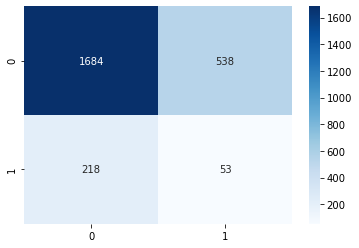

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf = confusion_matrix(test_y_all, preds_all)
#conf = conf/conf.astype(np.float).sum(axis=1)
sns.heatmap(conf, annot=True,fmt = 'd', cmap='Blues')

In [8]:
print(len(tp_list)+len(fp_list))
print(len(tn_list)+len(fn_list))


591
1902


In [9]:
print(len(tp_list))
print(len(tn_list))
print(len(fp_list))
print(len(fn_list))

53
1684
538
218


In [10]:
print(len(train_y))
print(len(test_y_all))
print(len(preds_all))

9641
2493
2493


In [11]:
print("Positives")
print(len([i for i in train_y if i == 1]))
print("negatives")
print(len([i for i in train_y if i == 0]))

Positives
1538
negatives
8103


In [12]:
print("Positives")
print(len([i for i in test_y_all if i == 1]))
print("negatives")
print(len([i for i in test_y_all if i == 0]))

Positives
271
negatives
2222


In [13]:
print("Positives")
print(len([i for i in preds_all if i == 1]))
print("negatives")
print(len([i for i in preds_all if i == 0]))

Positives
591
negatives
1902
